In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np
import seaborn as sns

def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)

#===========================================load config file====================================================================
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *

import yaml
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)
config = {}
with open("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml") as f:
    config = yaml.safe_load(f)
#======================================================================================================================================================
#samples = ['ggh500']#,'ggh600','ggh700','ggh800','ggh900','ggh1000','ggh1500','ggh2500','ggh3000']
branchs = 'GEN_H1_mass'
year = '2016'

In [88]:
branchs = ['GEN_H1_mass','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated',
                        'massmerged','ptmerged','mass2jet',
                        'mass2l2jet', 'mass2lj',]
samples = ['ggh500','ggh600','ggh700','ggh800','ggh900','ggh1000','ggh1500','ggh2500','ggh3000']
sig_arr, sumWeight = extractSpecialBranch(config,year,samples,branchs)

This is ggh500
This is ggh600
This is ggh700
This is ggh800
This is ggh900
This is ggh1000
This is ggh1500
This is ggh2500
This is ggh3000


# GEN Raw mass Higgs

In [89]:
sig_hist = []
nbins, xmin, xmax = 80,0,4000
edge = np.linspace(xmin, xmax, nbins+1)
for sample in samples:
    print(sample)
    #temp_arr = sig_arr[sample]
    weights = np.ones_like(sig_arr[sample]['GEN_H1_mass'])
    sig_hist.append(get_hist(sig_arr[sample]['GEN_H1_mass'],weights,nbins,xmin,xmax))

ggh500
ggh600
ggh700
ggh800
ggh900
ggh1000
ggh1500
ggh2500
ggh3000


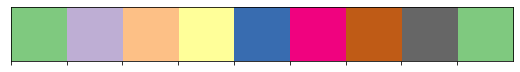

In [3]:
color_order = sns.color_palette('Accent', len(samples))
set_sns_color(color_order)

In [4]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

[INFO] DONE


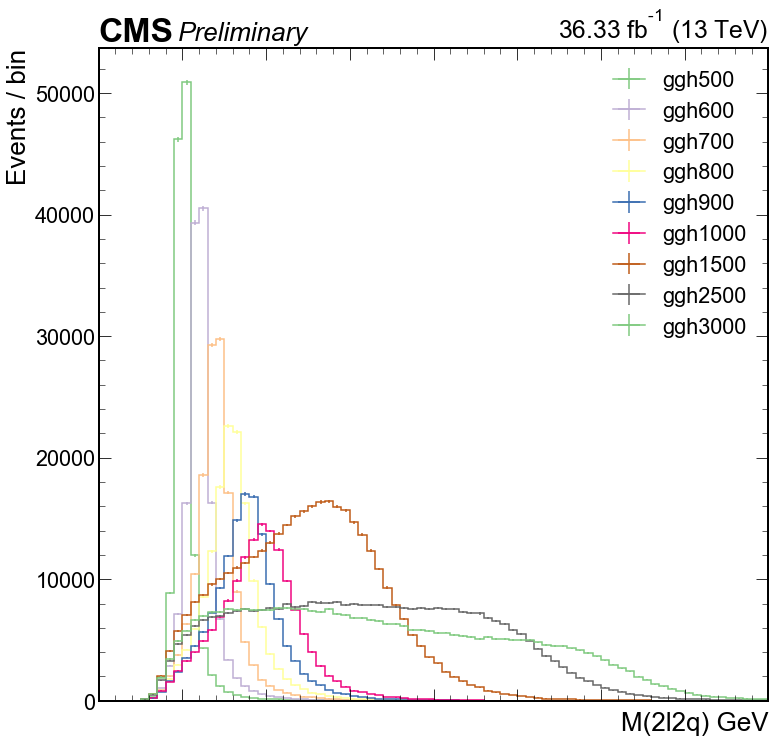

In [90]:
f = plt.figure(figsize=(12,12))
ax = f.add_subplot()
hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
ax.set_xlim(xmin, xmax); ax.set_xticklabels([]); ax.set_ylabel('Events / bin', ha='right', y=1.0)
ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
plot_hist(sig_hist,label=[ var for var in samples])
plt.legend()
plt.savefig(f'GenH.png')
print('[INFO] DONE')


# Raw Reco Plots

[INFO] DONE


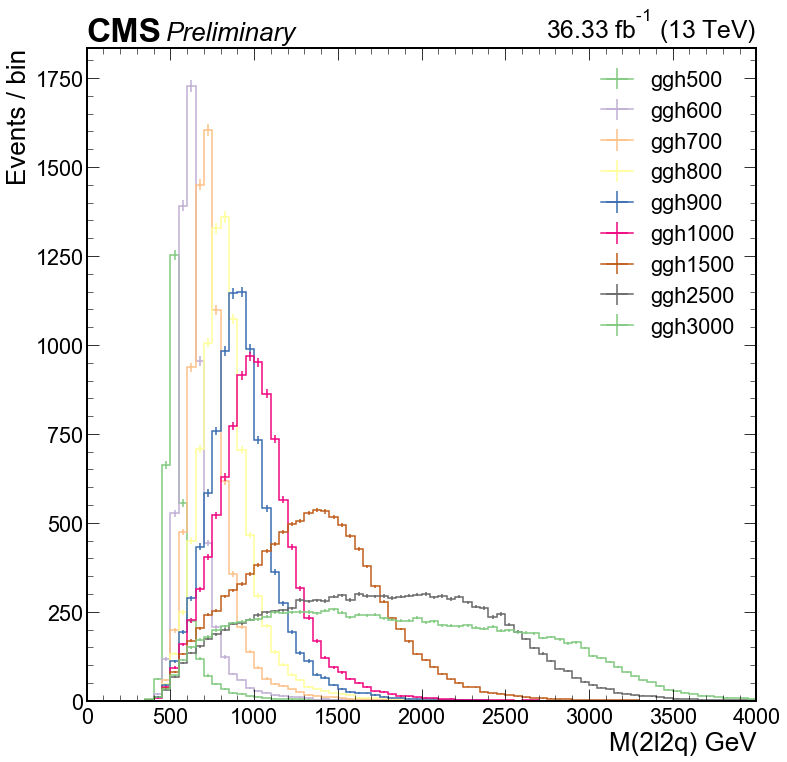

In [115]:
sig_arr_cut = {}
sig_hist_cut = []
selection = '((massmerged>70) & (massmerged<105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)'
for sample in samples:
    cut_array = ak.numexpr.evaluate(selection,sig_arr[sample])
    sig_arr_cut[sample] = sig_arr[sample][cut_array]
    weights = (sig_arr_cut[sample]['EventWeight']*config['lumi'][year]*config['samples_inf'][sample][1]*1000)/sumWeight[sample]
    temp_hist = get_hist(sig_arr_cut[sample]['mass2lj'],weights,nbins,xmin,xmax)
    sig_hist_cut.append(temp_hist)

######plot reco-plot
f = plt.figure(figsize=(12,12))
ax = f.add_subplot()
hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / bin', ha='right', y=1.0)
ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
plot_hist(sig_hist_cut,label=[ var for var in samples])
plt.legend()
plt.savefig(f'recoRaw_m2l2q.png')
print('[INFO] DONE')

# Re-shape reco-plots

In [92]:
def reshape(histo,mean,width):
    h = bh.Histogram(bh.axis.Regular(nbins, xmin, xmax))
    h.fill(np.random.normal(loc=mean, scale=width, size=int(histo.view().value.sum())))
    reshape_weight = h.view()/histo.view().value
    np.nan_to_num(reshape_weight,0)
    return reshape_weight

/tmp/ipykernel_19070/1924718592.py:4: RuntimeWarning: divide by zero encountered in true_divide
  reshape_weight = h.view()/histo.view().value
/tmp/ipykernel_19070/1924718592.py:4: RuntimeWarning: invalid value encountered in true_divide
  reshape_weight = h.view()/histo.view().value


[INFO] DONE


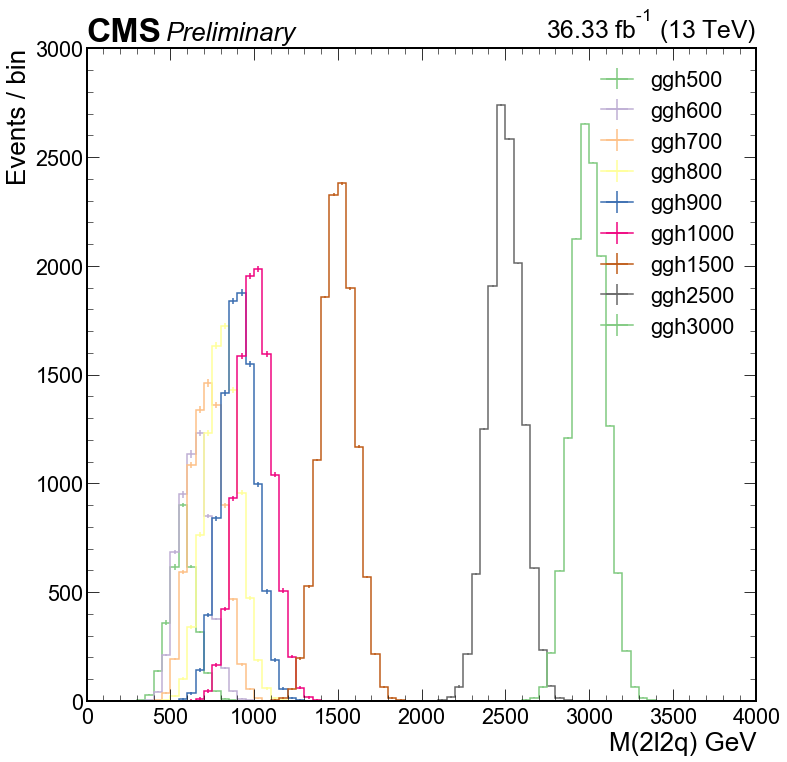

In [117]:
nSample = len(samples)
massList = [500,600,700,800,900,1000,1500,2500,3000]
width = 100
sig_hist_reshape = []
for i,sample in enumerate(samples):
    sig_hist_reshape.append(sig_hist_cut[i])
    re_weight = reshape(sig_hist[i],massList[i],width)
    sig_hist_reshape[i].view().value = (sig_hist_reshape[i].view().value)*re_weight

######plot reshaped reco-plot
f = plt.figure(figsize=(12,12))
ax = f.add_subplot()
hep.cms.label(data=True, llabel='Preliminary',year=year,rlabel=r'%s $fb^{-1}$ (13 TeV)'%config['lumi'][year], fontname='sans-serif')
ax.set_xlim(xmin, xmax); ax.set_ylabel('Events / bin', ha='right', y=1.0)
ax.set_xlabel(r'M(2l2q) GeV', ha='right', x=1.0)
plot_hist(sig_hist_reshape,label=[ var for var in samples])
ax.set_ylim(0, 3000)
plt.legend()
plt.savefig(f'recoReshaped_m2l2q.png')
print('[INFO] DONE')

# fit to DC Function

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd81e3bf2b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

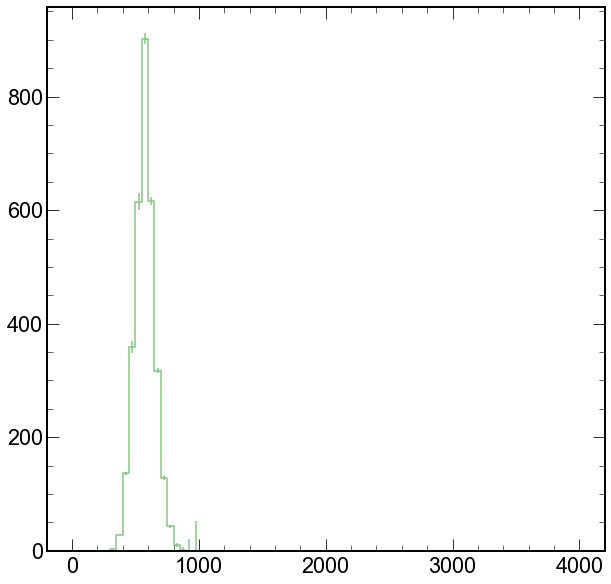

In [119]:
hep.histplot(sig_hist_reshape[0])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd83cebe880>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

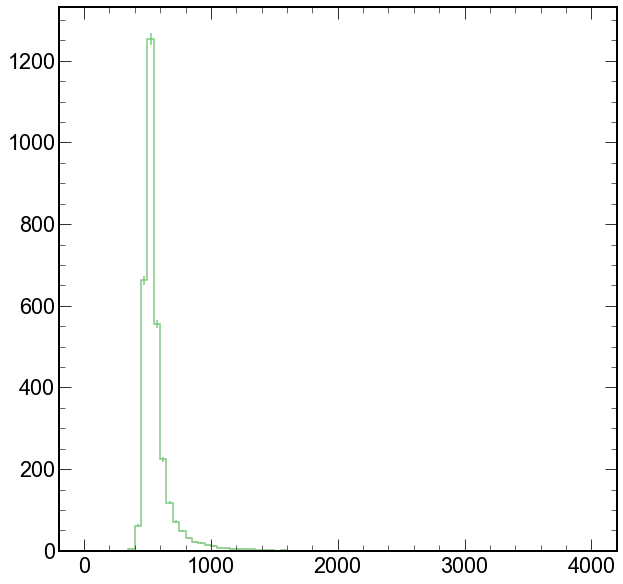

In [72]:
temp_hist.view().value = (temp_hist.view().value)*reshape_weight
hep.histplot(temp_hist)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd83c20d0a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

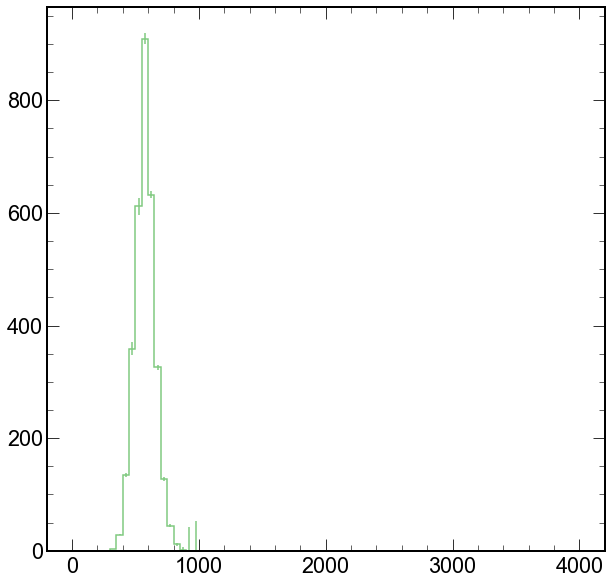

In [77]:
temp_hist.view().value = (temp_hist.view().value)*reshape_weight
hep.histplot(temp_hist)

In [84]:
sig_hist

[Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=130330, variance=130330),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (WeightedSum(value=140001, variance=140001) with flow),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=141795, variance=141795),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=144943, variance=144943),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=142835, variance=142835),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=153092, variance=153092),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=370630, variance=370630) (WeightedSum(value=370641, variance=370641) with flow),
 Histogram(Regular(80, 0, 4000), storage=Weight()) # Sum: WeightedSum(value=343204, variance=343204) (WeightedSum(value=343357, variance=343357) with flow),
 Histogram(Regular(80, 0, 400

/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd83c1527c0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

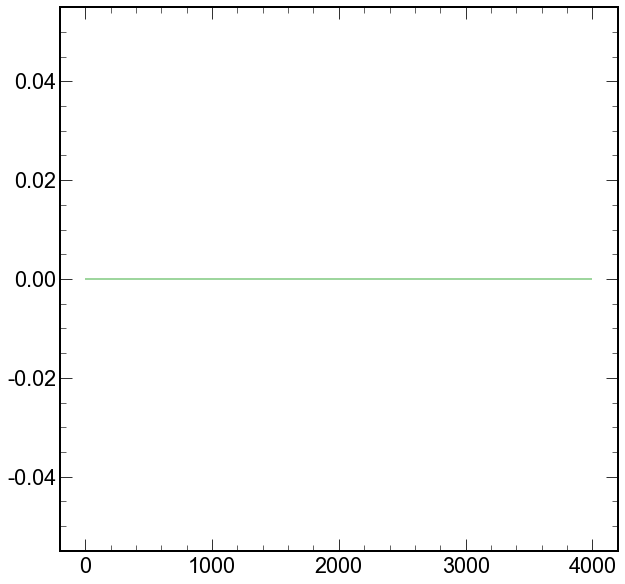

In [83]:
hep.histplot(sig_hist[1])